# One-way ANOVA

Imagine you have three groups, and you want to do a one-level ANOVA to test for
overall differences across the groups.

The general technique for a permutation test is:

* You decide on your metric
* You get your metric for the actual data - observed metric
* You permute your data and take the same metric from the permuted data, and
  repeat many times - fake metrics
* You compare your observed metric to your fake metrics, to see how unusual it
  is.

For a two-sample permutation test, your metric is the difference in the two
sample means.

For a three sample version of the test — we need a metric that will be big
where there are big differences between the three groups, and small when there
are small differences.

Let us reflect on what what we want from the metric.  It should be a single
number to summarize all the values from the groups. It should be be large for
big differences between the means for the various groups.  It should be larger
when more observations are in the groups with large difference in means.

Consider the following metric.  We will soon see this is the metric that the F-test uses.

* Get the sample means for each of the three groups A, B, C, to give `mean_a`,
  `mean_b`, `mean_c`
* Get the mean across all the observations regardless of group
  (`mean_overall`)
* Subtract `mean_overall` from each of `mean_a`, `mean_b`, `mean_c` to give
  `mean_a_diff`, `mean_b_diff`, `mean_c_diff`.
* We are interested in positive as well as negative differences, so we do not
  want to add these mean differences, otherwise the positive and negative means
  differences will cancel out. So we next square the differences to give:
  `sq_mean_a_diff`, `sq_mean_b_diff`, `sq_mean_c_diff`.
* We want larger groups to have greater weight than small groups.  Call the
  number in groups A, B, and C `n_a`, `n_b`, `n_c`. To weight the squared mean
  differences we multiply each square mean difference by the number in each
  group: `sq_mean_a_diff * n_a`, `sq_mean_b_diff * n_b`, `sq_mean_c_diff *
  n_b`, to give `nsq_mean_a_diff`, `nsq_mean_b_diff`, `n_sq_mean_c_diff`.
*   Finally, we add up the group `nsq` scores to give our metric:

    ```
    our_metric = nsq_mean_a_diff + nsq_mean_b_diff + nsq_mean_c_diff
    ```

We will call this the SNSQGMD metric (Sum of N times SQuared Group Mean
Difference).

SNSQGMD will be large and positive when the individual groups have different
means from each other and small when the means for the groups are pretty
similar to each other, and therefore, to the overall mean.  It will be larger
when larger groups have means with bigger deviations from the overall mean.

To follow the recipe above, we calculate SNSQGMD for the actual groups A, B, C.
Permute the group labels to give random groups A, B, C, and recalculate the
metric.   See whether SNSQGMD in the real data is unusual in the distribution of
the same metric for the permuted groups.

This is the permutation equivalent of the one-way ANOVA.   The one-way ANOVA
just uses some assumptions from the normal distribution to estimate the spread
in the random distribution of SNSQGMD, instead of using permutation to calculate
the random distribution.


## An example

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

Our dataset is a table giving the amount of weight lost for a group of people allocated to one of three possible diets, called `A`, `B` and `C`.

See: [the dataset page](https://github.com/odsti/datasets/tree/master/sheffield_diet) for more detail.

In [2]:
# Read the raw dataset
diets = pd.read_csv('sheffield_diet.csv')
diets.head()

,diet,weight_lost
0,B,0.0
1,B,0.0
2,A,3.8
3,A,6.0
4,A,0.7


Each row corresponds to one person. The `diet` column names the diet to which
that person was allocated.  The `weight_lost` column has the number of
kilograms weight lost by that person after 10 weeks of following the diet.

We are interested to know if the diets `A`, `B` and `C` differ overall in the
amount of weight loss for people on that diet.

We will call sometimes call the allocated diet the *group* to which the person
(row) belongs.


## Means by group

Here are the data, plotted by group.

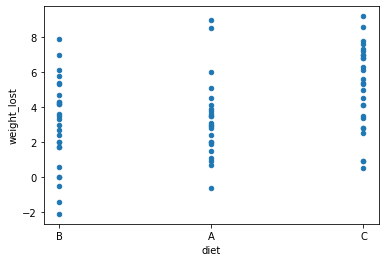

In [3]:
diets.plot.scatter('diet', 'weight_lost');

These are the means for each of the three groups.

In [4]:
group_means = diets.groupby('diet').mean()
group_means

,weight_lost
diet,
A,3.300000
B,3.025926
C,5.148148


These are the number of observations per group:

In [5]:
group_ns = diets.groupby('diet').count()
group_ns

,weight_lost
diet,
A,24
B,27
C,27


Here is the overall mean, ignoring the group membership:

In [6]:
overall_mean = np.mean(diets['weight_lost'])
overall_mean

3.8448717948717945

The next plot shows the data, the group means, and the overall mean:

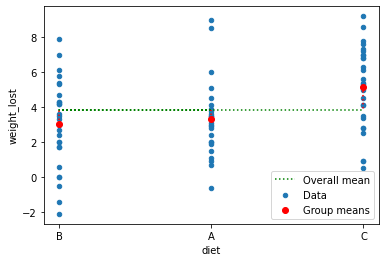

In [7]:
diets.plot.scatter('diet', 'weight_lost',
                         label='Data')
plt.scatter(group_means.index, np.array(group_means), color='red',
            label='Group means')
# A dashed line at the overall mean.
plt.plot(group_means.index,
         [overall_mean, overall_mean, overall_mean],
         ':', color='green',
         label='Overall mean')
# A dashed line between each group mean and the overall mean.
for group in group_means.index:
    xs = [group, group]
    ys = [float(group_means.loc[group]), overall_mean]
    plt.plot(xs, ys, ':', color='red')
plt.legend();

Notice the red dashed lines between the group means and the overall mean.  To make these easier to see, here is the same plot, without the individual data points:

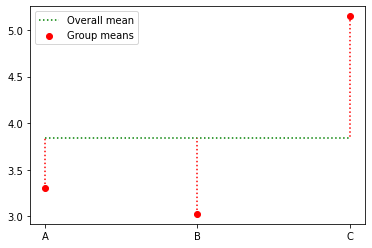

In [8]:
plt.scatter(group_means.index, np.array(group_means), color='red',
            label='Group means')
# A dashed line at the overall mean.
plt.plot(group_means.index,
         [overall_mean, overall_mean, overall_mean],
         ':', color='green',
         label='Overall mean')
# A dashed line between each group mean and the overall mean.
for group in group_means.index:
    xs = [group, group]
    ys = [float(group_means.loc[group]), overall_mean]
    plt.plot(xs, ys, ':', color='red')
plt.legend();

We designed our SNSQGMD metric to be large when the sum of the squared lengths of
these lines are large.  The N in  SNSQGMD reminds us we multiply each squared
length by the number in the group, to give more weight to large groups.

To calculate SNSQGMD we get the Group Mean Difference.

In [9]:
gmd = group_means - overall_mean
gmd

,weight_lost
diet,
A,-0.544872
B,-0.818946
C,1.303276


We square these differences:

In [10]:
sq_gmd = gmd ** 2
sq_gmd

,weight_lost
diet,
A,0.296885
B,0.670672
C,1.698529


We want to give more weight to groups with more members, so we multiply each squared difference by the number in the group:

In [11]:
n_sq_gmd = sq_gmd * group_ns
n_sq_gmd

,weight_lost
diet,
A,7.125247
B,18.108153
C,45.860290


Finally, we add up these weighted squares to get the final metric:

In [12]:
observed_sn_sq_gmd = np.sum(n_sq_gmd)
observed_sn_sq_gmd

weight_lost    71.093689
dtype: float64

This is our metric.  To make this a bit clearer, we put the calculation of our
metric into its own function so we can re-use it on different data frames.

In [13]:
def get_sn_sq_gmd(df, group_col, val_col):
    overall_mean = np.mean(df[val_col])
    grouped = df.groupby(group_col)[val_col]
    sq_gmd = (grouped.mean() - overall_mean) ** 2
    return np.sum(sq_gmd * grouped.count())

Check that we get the same answer from the function as we did with the step-by-step calculation:

In [14]:
get_sn_sq_gmd(diets, 'diet', 'weight_lost')

71.09368945868938

Next we consider a single trial in our ideal, null, fake world.  We do this by
making a copy of the data frame, and then permuting the diet labels, so
the association between the diet and the change values is random.

In [15]:
fake_data = diets.copy()
# Permute the treatment labels
fake_data['diet'] = np.random.permutation(fake_data['diet'])
fake_data.head()

,diet,weight_lost
0,A,0.0
1,B,0.0
2,B,3.8
3,C,6.0
4,A,0.7


Next we calculate our metric step by step.

In [16]:
fake_grouped = fake_data.groupby('diet')['weight_lost']
# Notice that the overall_mean cannot change because we did not
# change these values.
fake_sq_gmd = (fake_grouped.mean() - overall_mean) ** 2
fake_sn_sq_gmd = np.sum(fake_sq_gmd * fake_grouped.count())
fake_sn_sq_gmd

11.793689458689478

We can also use our function to do that calculation, to get the same answer:

In [17]:
get_sn_sq_gmd(fake_data, 'diet', 'weight_lost')

11.793689458689478

Now we are ready to do our simulation.  We do 10000 trials, making a new random
association, and recalculating our sum of squares metric.

In [18]:
n_iters = 10000
fake_sn_sq_gmds = np.zeros(n_iters)
for i in np.arange(n_iters):
    # Make sample from null world.
    fake_data['diet'] = np.random.permutation(fake_data['diet'])
    # Calculate corresponding metric.
    fake_sn_sq_gmds[i] = get_sn_sq_gmd(fake_data, 'diet', 'weight_lost')

Of course, because these are sums of squares, they must all be positive.

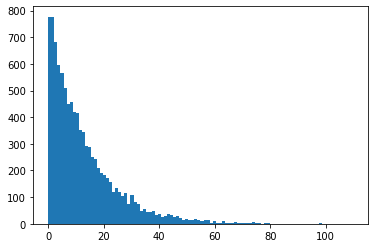

In [19]:
plt.hist(fake_sn_sq_gmds, bins=100);

How does our observed sum of squares metric compare to the distribution of fake
sum of square metrics?

In [20]:
p = np.count_nonzero(fake_sn_sq_gmds >= float(observed_sn_sq_gmd)) / n_iters
p

0.0037

The p value tells us that this observed metric is very unlikely to have come
about in a random world.


## Comparing to standard one-way ANOVA F tests

Here we do the standard F-test calculations to show that we get a similar p
value to the permutation version above.  Here is the Statsmodels
implementation of the one-way F test:

In [21]:
import statsmodels.api as sm
import statsmodels.formula.api as smf

mod = smf.ols('weight_lost ~ diet', data=diets).fit()

sm.stats.anova_lm(mod, typ=1)

,df,sum_sq,mean_sq,F,PR(>F)
diet,2.0,71.093689,35.546845,6.197447,0.003229
Residual,75.0,430.179259,5.735723,NaN,NaN


Here is the same calculation in Scipy:

In [22]:
from scipy.stats import f_oneway

In [23]:
# Get the values from the individual groups.
treatment = diets['diet']
change = diets['weight_lost']
diet_a = change[treatment == 'A']
diet_b = change[treatment == 'B']
diet_c = change[treatment == 'C']

Do the F-test:

In [24]:
f_result = f_oneway(diet_a, diet_b, diet_c)
f_result

F_onewayResult(statistic=6.197447453165349, pvalue=0.0032290142385893524)

## The F statistic and the SNSQGMD metric

In this section, we go into more detail about the calculation of the F value that you see above, in the F tests.  Here is the calculated F statistic from Scipy.  You have seen we got the same value from Statsmodels.

In [25]:
F_stat = f_result.statistic
F_stat

6.197447453165349

This section goes through the calculation of the F statistic from the SNSQGMD metric.  This is the value we got for that metric:

In [26]:
observed_sn_sq_gmd

weight_lost    71.093689
dtype: float64

You can get the F statistic above by dividing the SNSQGMD metric by a scaled estimate of the variation still present in the data.

The variation still present in the data are the remaining distances between the
data (in the plot above) and their corresponding group means.  Call these
remaining distances the "residuals".

Here are the group means:

In [27]:
group_means

,weight_lost
diet,
A,3.300000
B,3.025926
C,5.148148


We are going to put the group means into their own column in the original data frame, in order to subtract them from the individual values.  First we make a new copy of the group means, but renaming the value column for later.

In [28]:
gms_renamed = group_means.rename(columns={"weight_lost": "vol_chg_mean"})
gms_renamed

,vol_chg_mean
diet,
A,3.300000
B,3.025926
C,5.148148


Next we merge this group means data frame into the original table, to give every row its corresponding group mean.

In [29]:
diets_and_means = diets.merge(gms_renamed, on='diet')
diets_and_means.head()

,diet,weight_lost,vol_chg_mean
0,B,0.0,3.025926
1,B,0.0,3.025926
2,B,-2.1,3.025926
3,B,2.0,3.025926
4,B,1.7,3.025926


Now we can calculate the residuals by subtracting the corresponding group mean from each hand volume change value.

In [30]:
diets_and_means['resid'] = (diets_and_means['weight_lost'] -
                            diets_and_means['vol_chg_mean'])
diets_and_means.head()

,diet,weight_lost,vol_chg_mean,resid
0,B,0.0,3.025926,-3.025926
1,B,0.0,3.025926,-3.025926
2,B,-2.1,3.025926,-5.125926
3,B,2.0,3.025926,-1.025926
4,B,1.7,3.025926,-1.325926


Next we give a number (metric) to the residuals by squaring (to remove the signs) and adding:

In [31]:
ssq_resid_groups = np.sum((diets_and_means['resid']) ** 2)
ssq_resid_groups

430.1792592592592

The F-statistic results from dividing this measure of remaining variation
into the SNSQGMD metric, with some scaling.  The scaling comes from the number of observations, and the number of groups.

In [32]:
n_obs = len(diets_and_means)
n_groups = len(group_means)

Here is the full calculation of the F-statistic. Notice that it is exactly the same as we got from Scipy and Statsmodels.

In [33]:
# Calculate of the F value by scaling and dividing by residual variation
# metric.
df_groups = n_groups - 1  # Degrees of freedom for groups.
df_error = n_obs - n_groups  # Degrees of freedom for residuals.
# The F statistic
(observed_sn_sq_gmd / df_groups) / (ssq_resid_groups / df_error)

weight_lost    6.197447
dtype: float64

Scaling and dividing by the residual variation gives a value that we can reason
about with some standard mathematics, as long as we are prepared to assume that
the distribution of the values is normal.  Specifically, with those assumptions, we can get a p value by comparing the observed F value to a standard F distribution with the same "degrees of freedom".  These are the `df_groups` and `df_error` values above.

As you have seen, the permutation estimate gives a very similar answer.  We would argue that it is also a lot easier to explain.


## F tests in terms of explained variation

You will often see explanations of the F-value in terms of the amount of
variation explained by the overall mean, compared to the amount of variation
explained with the individual group means.  In fact, this "variance" way of
thinking is what gave the test the name ANOVA (Analysis of Variance).

The explained variation path (literally) adds up to the same thing as the
SNSQGMD metric version of the F statistic above.  This section goes through the
explained variation way of thinking of the F statistic, and shows that it
gives the same value for the SNSQGMD metric.

The "variance" way of thinking about the F looks at the sum of squared
"residual" variation in two situations.  First we get the residual variation
when we subtract the group means.  We already have this from the F test
calculation above.  As a reminder, we repeat the calculation here:

In [34]:
ssq_resid_groups = np.sum((diets_and_means['resid']) ** 2)
ssq_resid_groups

430.1792592592592

This is the sum of squared remaining variation when using the group means.

We compare this to the squared remaining variation when just using the overall mean.  Here is that calculation.

In [35]:
# Sum of squared residuals using overall mean
# Subtract the overall mean from the original values to get residuals.
resid_overall = diets['weight_lost'] - overall_mean
# Square and sum the residuals to get the squared variation from overall mean.
ssq_resid_overall = np.sum(resid_overall ** 2)
ssq_resid_overall

501.2729487179484

The variance way of thinking says that we should be particularly interested in
our group means, when using them does a very good job of reducing the
variation.  This will happen when the group values are a lot closer to their
individual group means, than they are to the overall mean.  In that case,
`ssq_resid_groups` will be much lower than `ssq_resid_overall`, so we will get
a fairly high value for `ssq_resid_overall - ssq_resid_groups`.  The result of
this subtraction is called the *extra sum of squares* explained by the sample
means:

In [36]:
ess = ssq_resid_overall - ssq_resid_groups
ess

71.0936894586892

Remember, `ssq_resid_overall` is the (sum of squared) variation remaining after accounting for the overall mean, and `ssq_resid_groups` is the (sum of squared) variation remaining after accounting for the sample means, so `ess` is the *extra* variation accounted for by using the sample means.

But — wait — the `ess` value is *exactly* the same as the SNSQGMD metric we
were already using!

In [37]:
observed_sn_sq_gmd

weight_lost    71.093689
dtype: float64

This striking fact is true for any possible values and groups, and arises from
the algebra of adding squared deviations from means.  The equivalence gives us
two different ways of thinking of the same SNSQGMD metric value.  The SNSQGMD
value is both:

* A measure of how far the sample means are from the overall mean, AND
* A measure of how much variation the sample means explain, over and above the
  overall mean.

In this second "explained variance" interpretation, we think of the F test
calculation as being a scaled ratio of the extra variance explained by the
sample means to the variance still remaining when we use the sample means.  If
the sample means explain a lot of variation, then the top half of the F
statistic will be large, and the bottom half will be small, giving a large F
value.